The Label of the 8980-th example is 4
The corresponding data is at below.


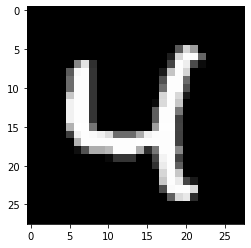

In [24]:
###################
# Pick An Example #
###################

#[Input Vars]
#  1. <int> i: the index of the training dataset
#  2. <dataframe> DF_TRAIN: Dataframe-like format
#
#[Output Vars]
#  1. <ndarray> X: Image
#  2. <ndarray> Y: The label to the image

import numpy as np

def pick_an_example(i, DF_TRAIN):
    X = DF_TRAIN[i:i+1].values[0][1:].reshape(28,28,1)
    Y = DF_TRAIN[i:i+1].values[0][0]
    return X, Y

i = np.random.randint(len(DF_TRAIN))
X, Y = pick_an_example(i, DF_TRAIN)
print(f"The Label of the {i}-th example is {Y}\nThe corresponding data is at below.")
plt.imshow(X, cmap=plt.get_cmap('gray'))
plt.show()

In [2]:
################
# Zero Padding #
################

#[Input Vars]
#  1. <ndarray> X: Unpadded image. The shape is (n_H_prev, n_W_prev, n_C_prev).
#  2. <int> pad: expected number of pads on each side. The shape is (n_H_prev + 2 * pad, n_W_prev + 2 * pad, n_C_prev).
#
#[Output Vars]
#  1. <ndarray> X_pad: Padded image.

import numpy as np

def __zero_pad(X, pad):
    X_pad = np.pad(X, ((pad, pad), (pad, pad),(0,0)), "constant", constant_values = 0)
    return X_pad

#X_pad = __zero_pad(X, 2)

#plt.imshow(X_pad, cmap=plt.get_cmap('gray'))
#plt.show()

In [3]:
####################
# Conv Single Step #
####################

#[Input Vars]
#  1. <ndarray> a_slice_prev: slice of previous feature maps. The shape is (f, f, n_C_prev).
#  2. <ndarray> K: A single weight matrix (kernel). The shape is (f, f, n_C_prev).
#  3. <ndarray> b: A single bias term. The shape is (1, 1, 1).
#
#[Output Vars]
#  1. <float> Z: a scalar derived from convolution operation.

import numpy as np

def __conv_single_step(s_slice, K, b):
    
    S = np.multiply(s_slice, K)
    Z = np.sum(S)
    Z = Z + float(b)
    
    return Z

In [4]:
############################
# Conv Forward Propagation #
############################

#[Input Vars]
#  1. <ndarray> S_prev: The previous feature maps (after activation and pooling). The shape is (n_H_prev, n_W_prev, n_C_prev).
#  2. <ndarray> K: Kernels in a layer. The shape is (f, f, n_C_prev, n_C).
#  3. <ndarray> b: biases in a layer. THe shape is (1, 1, 1, n_C).
#  4. <dictionary> hparam: this contains hyper parameters like "pad" and "stride".
#
#[Output Vars]
#  1. <ndarray> C: This would be the feature map in the next layer (but before activation). The shape is (n_H, n_W, n_C).
#  2. <dictionary> cache: Cache the values needed for backward propagation.

import numpy as np

def conv_forward(S_prev, K, b, hparam):
    
    # 1. Retrieve shape of A_prev. We need this to compute the shape of the feature map in the next layer.
    (n_H_prev, n_W_prev, n_C_prev) = S_prev.shape
    
    # 2. Retrieve shape of K. We also need this (i.e. f) to compute the shape of the feature map in the next layer.
    (f, f, n_C_prev, n_C) = K.shape
    
    # 3. Retrieve info. from hyper parameters. We need them to compute the shape of the feature map in the next layer, too.
    stride = hparam["stride"]
    pad = hparam["pad"]
    
    # 4. With info from 1. ~ 3., we can compute the dimension for the feature map in the next layer.
    n_H = int((n_H_prev - f + 2 * pad) / stride) + 1
    n_W = int((n_W_prev - f + 2 * pad) / stride) + 1
    
    # 5. Initialize feature maps in the next layer with zeros. Note #Kernel is equal to #Channel of the feature map.
    C = np.zeros((n_H, n_W, n_C))
    
    # 6. Pad S_prev
    S_prev_pad = __zero_pad(S_prev, pad)
    
    # 7. Do Cross-Relation Operation. Note the shape of the output feature map would be (n_H, n_W, n_C).
    for h in range(n_H):
        for w in range(n_W):
            for c in range(n_C):
                
                # Define the corners in the S_prev_pad.
                vert_head = h * stride
                vert_tail = vert_head + f
                hori_head = w * stride
                hori_tail = hori_head + f
                
                # Get the slice.
                S_prev_slice = S_prev_pad[vert_head:vert_tail, hori_head:hori_tail, :]
                
                # Feed it into __conv_single_step(a_slice, K, b). Note we use one kernel and one bias term at once.
                C[h, w, c] = __conv_single_step(S_prev_slice, K[:,:,:,c], b[:,:,:,c])
    
    # 8. Check if the output feature map have the valid shape.
    assert(C.shape == (n_H, n_W, n_C))
    
    # 9. Store the cache for backward propagation
    cache = (S_prev, K, b, hparam)
    
    return C, cache

In [5]:
############################
# Pool Forward Propagation #
############################

#[Input Vars]
#  1. <ndarray> A_prev: The previous feature maps (after activation). The shape is (n_H_prev, n_W_prev, n_C_prev).
#  2. <dictionary> hparam: It contains "f" and "stride".
#  3. <string> mode: Switch between "maxpooling" and "avgpooling". The shape is (n_H, n_W, n_C). (n_C = n_C_prev)
#
#[Output Vars]
#  1. <ndarray> S: The output feature map after pooling operation.

import numpy as np

def pool_forward(A_prev, hparam, mode = "maxpooling"):
    # 1. Retrieve shape of A_prev.
    (n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    # 2. Retrieve info from hyper parameter
    f = hparam["f"]
    stride = hparam["stride"]

    # 3. Define the shape of output of pooling operation.
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev

    # 4. Initialize the output feature map after pooling operation with zeros.
    S = np.zeros((n_H, n_W, n_C))
    
    # 5. Do Pooling Operation
    for h in range(n_H):
        for w in range(n_W):
            for c in range(n_C):
                
                # Define the corners in the A_prev_pad.
                vert_head = h * stride
                vert_tail = vert_head + f
                hori_head = w * stride
                hori_tail = hori_head + f
                
                # Get the slice. (Note that there's only one channel involved. Not like conv_forward)
                A_prev_slice = A_prev[vert_head:vert_tail, hori_head:hori_tail, c]
                
                # Pooling operation
                if mode == "maxpooling":
                    S[h, w, c] = np.max(A_prev_slice)
                elif mode == "avgpooling":
                    S[h, w, c] = np.mean(A_prev_slice)
                    
    # 6. Check if the output feature map have the valid shape.
    assert(S.shape == (n_H, n_W, n_C))
    
    # 7. Store the cache for backward propagation
    cache = (A_prev, hparam)
    
    return S, cache

In [6]:
#############################
# Conv Backward Propagation #
#############################

#[Input Vars]
#  1. <ndarray> dC: gradient of the cost with respect to the output of the conv layer (C). The shape is (n_H, n_W, n_C).
#  2. <dictionary> cache: Cache of output of conv_forward()
#
#[Output Vars]
#  1. <ndarray> dS_prev: gradient of the cost w.r.t. the input of the conv layer (S). The shape is (n_H_prev, n_W_prev, n_C_prev).
#  2. <ndarray> dK: gradient of the cost w.r.t. the weights of the conv layer (K). The shape is (f, f, n_C_prev, n_C).
#  3. <ndarray> db: gradient of the cost w.r.t. the biases of the conv layer (b). The shape is (1, 1, 1, n_C).

def conv_backward(dC, cache):
    
    # 1. Retrieve info. from cache.
    (S_prev, K, b, hparam) = cache
    
    # 2. Retrieve the shape of S_prev.
    (n_H_prev, n_W_prev, n_C_prev) = S_prev.shape
    
    # 3. Retrieve the shape of Kernel.
    (f, f, n_C_prev, n_C) = K.shape
    
    # 4. Retieve info. from hyper parameters.
    stride = hparam["stride"]
    pad = hparam["pad"]
    
    # 5. Retrieve the shape of dC
    (n_H, n_W, n_C) = dC.shape
    
    # 6. Initialize dS_prev, dK, db with the correct shapes.
    dS_prev = np.zeros((n_H_prev, n_W_prev, n_C_prev))
    dK = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))
    
    # 7. Pad dS_prev and S_prev
    S_prev_pad = __zero_pad(S_prev, pad)
    dS_prev_pad = __zero_pad(dS_prev, pad)
    
    # 8. Do backward pass operation
    for h in range(n_H):
        for w in range(n_W):
            for c in range(n_C):
                                
                # Define the corners in the A_prev_pad.
                vert_head = h * stride
                vert_tail = vert_head + f
                hori_head = w * stride
                hori_tail = hori_head + f
                    
                # Get the slice.
                S_prev_slice = S_prev_pad[vert_head:vert_tail, hori_head:hori_tail, :]
                
                # Update Gradients (dS_prev, dK, db) for the window
                dS_prev_pad[vert_head:vert_tail, hori_head:hori_tail, :] += K[:,:,:,c] * dC[h, w, c]
                dK[: , :, :, c] += S_prev_slice * dC[h, w, c]
                db[: , :, :, c] += dC[h, w, c]
                
    # 9. Unpad dS_prev_pad
    if (pad == 0):
        dS_prev = dS_prev_pad
    else:
        dS_prev[:, :, :] = dS_prev_pad[pad:-pad, pad:-pad, :]
    
    
    # 10 Check the validity of the shape
    assert (dS_prev.shape == (n_H_prev, n_W_prev, n_C_prev))
    
    return dS_prev, dK, db

In [7]:
############################
# Max Pool Backward helper #
############################

import numpy as np

def __create_mask_from_window(s):
    mask = (s == np.max(s))
    return mask

############################
# Avg Pool Backward helper #
############################

def __distribute_value(ds, shape):
    
    # 1. Retrieve dimensions from shape
    (n_H, n_W) = shape
    
    # 2. Compute the value to distribute on the matrix
    average = ds / (n_H * n_W)
    
    # 3. Create a matrix where each entry is the avg. value.
    a = np.ones(shape) * average
    return a

In [8]:
#############################
# Pool Backward Propagation #
#############################

#[Input Vars]
#  1. <ndarray> dS: gradient of cost w.r.t. the output of the pooling layer. The shape is the same as the shape of S.
#  2. <dictionary> cache: It contaions the output from the forward pass.
#  3. <string> mode: Switch between "maxpooling" and "avgpooling".
#
#[Output Vars]
#  1. <ndarray> dA_prev: gradient of cost w.r.t. the input of the pooling layer. The shape is the same as the shape of A_prev.

import numpy as np

def pool_backward(dS, cache, mode = "maxpooling"):
    
    # 1. Retrieve info. from cache
    (A_prev, hparam) = cache
    
    # 2. Retrieve hyper parameters
    stride = hparam["stride"]
    f = hparam["f"]
    
    # 3. Retrieve the shapes of A_prev and dS
    n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    n_H, n_W, n_C = dS.shape
    
    # 4. Initialize dA_prev with zeros.
    dA_prev = np.zeros((n_H_prev, n_W_prev, n_C_prev))
    
    # 5. Do Backward Pass Operation
    for h in range(n_H):
        for w in range(n_W):
            for c in range(n_C):
                                
                # Define the corners in the A_prev_pad.
                vert_head = h * stride
                vert_tail = vert_head + f
                hori_head = w * stride
                hori_tail = hori_head + f
                
                # Compute the backward propagation in both modes
                if mode == "maxpooling":
                    # Use the corners and the specific "c" tp defome the current slice of A_prev
                    A_prev_slice = A_prev[vert_head:vert_tail, hori_head:hori_tail, c]
                    
                    # Create the mask from A_prev_slice
                    mask = __create_mask_from_window(A_prev_slice)
                    
                    # Update dA_prev
                    dA_prev[vert_head:vert_tail, hori_head:hori_tail, c] += np.multiply(mask, dS[h, w, c])
                elif mode == "avgpooling":
                    # Get the entry ds from dS
                    ds = dS[h, w, c]
                    
                    # Define the shape of the kernel as (f, f).
                    shape = (f, f)
                    
                    # Distribute it (ds) to the correct slice of dA_prev
                    dA_prev[vert_head:vert_tail, hori_head:hori_tail, c] += __distribute_value(ds, shape)
    
    # 6. Check the dA_prev has the valid shape 
    assert (dA_prev.shape == A_prev.shape)
    
    return dA_prev

In [9]:
#####################################
# Functions for Forward Propagation #
#####################################

# [Input Vars]
#   1. <ndarray> Z
#
# [Output Vars]
#   1. <ndarray> A

import numpy as np

def __sigmoid(Z):
    A = 1/(1 + np.exp(-Z))
    return A

# [Input Vars]
#   1. <ndarray> A
#
# [Output Vars]
#   1. <ndarray> Y_pred
def __softmax(A):
    Y_pred = np.exp(A-np.max(A))/np.sum(np.exp(A-np.max(A)))
    return Y_pred

In [10]:
# Initiallize the Kernels, Biases, and hparams

def Initialize_Parameters(low, high):
    
    # C1
    K_C1 = np.random.uniform(low=low, high=high, size=(5, 5, 1, 6))
    b_C1 = np.random.uniform(low=low, high=high, size=(1, 1, 1, 6))
    hparam_C1 = {"stride": 1, "pad": 2}

    # S2
    hparam_S2 = {"f": 2, "stride": 2}

    # C3
    K_C3 = np.random.uniform(low=low, high=high, size=(5, 5, 6, 16))
    b_C3 = np.random.uniform(low=low, high=high, size=(1, 1, 1, 16))
    hparam_C3 = {"stride":1, "pad": 0}

    # S4
    hparam_S4 = {"f": 2, "stride": 2}

    # C5
    K_C5 = np.random.uniform(low=low, high=high, size=(5, 5, 16, 120))
    b_C5 = np.random.uniform(low=low, high=high, size=(1, 1, 1, 120))
    hparam_C5 = {"stride":1, "pad": 0}

    # W7
    W7 = np.random.uniform(low=low, high=high, size=(120, 84))

    # W8
    W8 = np.random.uniform(low=low, high=high, size=(84, 10))
    
    return K_C1, b_C1, hparam_C1, hparam_S2, K_C3, b_C3, hparam_C3, hparam_S4, K_C5, b_C5, hparam_C5, W7, W8

In [11]:

# LeNet5 - Forward Propagation

def LeNet5_forward(X, K_C1, b_C1, hparam_C1, hparam_S2, K_C3, b_C3, hparam_C3, hparam_S4, K_C5, b_C5, hparam_C5, W7, W8):

    #print(f"[X : Input] The shape of X is {X.shape}.")

    X_C1, cache_C1 = conv_forward(X, K_C1, b_C1, hparam_C1)
    #print(f"[C1: Padding and Convolution] The shape becomes {X_C1.shape}.")

    X_A1 = __sigmoid(X_C1)
    #print(f"[A1: Activatiion] The shape remain {X_A1.shape}")

    X_S2, cache_S2 = pool_forward(X_A1, hparam_S2, mode = "avgpooling")
    #print(f"[S2: Pooling] The shape becomes {X_S2.shape}.")

    X_C3, cache_C3 = conv_forward(X_S2, K_C3, b_C3, hparam_C3)
    #print(f"[C3: Padding and Convolution] The shape becomes {X_C3.shape}.")

    X_A3 = __sigmoid(X_C3)
    #print(f"[A3: Activatiion] The shape remain {X_A3.shape}.")

    X_S4, cache_S4 = pool_forward(X_A3, hparam_S4, mode = "avgpooling")
    #print(f"[S4: Pooling] The shape becomes {X_S4.shape}.")

    X_C5, cache_C5 = conv_forward(X_S4, K_C5, b_C5, hparam_C5)
    #print(f"[C5: Perform Padding and Convolution] The shape becomes {X_C5.shape}.")

    X_A5 = __sigmoid(X_C5)
    #print(f"[A5: Activatiion] The shape remain {X_A5.shape}.")

    X_A6 = X_A5.reshape(1, 120)
    #print(f"[A6: Reshape] The shape becomes {X_A6.shape}.")

    X_Z7 = np.dot(X_A6, W7)
    #print(f"[Z7: Linear] The shape becomes {X_Z7.shape}.")

    X_A7 = __sigmoid(X_Z7)
    #print(f"[A7: Activatiion] The shape remain {X_A7.shape}.")

    X_Z8 = np.dot(X_A7, W8)
    #print(f"[Z7: Linear] The shape becomes {X_Z8.shape}.")

    X_A8 = __sigmoid(X_Z8)
    #print(f"[A8: Activatiion] The shape remain {X_A8.shape}.")

    Y_pred = __softmax(X_A8)
    #print(f"[Y_pred: Softmax] The shape remain {Y_pred.shape}")
    
    return cache_C1, X_A1, cache_S2, cache_C3, X_A3, cache_S4, cache_C5, X_A5, X_A6, X_A7, X_A8, Y_pred

In [12]:
def cross_entropy(Y_pred, Y_truth):
    Error = (-1 * Y_truth * np.log(Y_pred)).sum()
    return Error

In [13]:
# LeNet5 - Backward Propagation
def LeNet5_backward(cache_C1, X_A1, cache_S2, cache_C3, X_A3, cache_S4, cache_C5, X_A5, X_A6, X_A7, X_A8, Y_pred, Y_truth):
    D_A8 = Y_pred - Y_truth
    #print(f"[D_A8:    Softmax] The shape is {D_A8.shape}.")

    D_Z8_local = np.multiply(1 - X_A8, X_A8)
    D_Z8 = np.multiply(D_Z8_local, D_A8)
    #print(f"[D_Z8: Activation] The shape is {D_Z8.shape}.")

    D_W8 = np.outer(X_A7, D_Z8)
    #print(f"[D_W8:    Product] The shape is {D_W8.shape}.")

    D_A7 = np.dot(D_Z8, D_W8.T)
    #print(f"[D_A7:    Product] The shape is {D_A7.shape}.")

    D_Z7_local = np.multiply(1 - X_A7, X_A7)
    D_Z7 = np.multiply(D_Z7_local, D_A7)
    #print(f"[D_Z7: Activation] The shape is {D_Z7.shape}.")

    D_W7 = np.outer(X_A6, D_Z7)
    #print(f"[D_W7:    Product] The shape is {D_W7.shape}.")

    D_A6 = np.dot(D_Z7, D_W7.T)
    #print(f"[D_A6:    Product] The shape is {D_A6.shape}.")

    D_A5 = D_A6.reshape(1,1,120)
    #print(f"[D_A5:    Reshape] The shape is {D_A5.shape}.")

    D_C5_local = np.multiply(1 - X_A5, X_A5)
    D_C5 = np.multiply(D_C5_local, D_A5)
    #print(f"[D_C5: Activation] The shape is {D_C5.shape}.")

    D_S4, D_K_C5, D_b_C5 = conv_backward(D_C5, cache_C5)
    #print(f"[D_S4: Conv. Back] The shape is {D_S4.shape}.")
    #print(f"[D_K_C5:   Kernel] The shape is {D_K_C5.shape}.")
    #print(f"[D_b_C5:     Bias] The shape is {D_b_C5.shape}.")

    D_A3 = pool_backward(D_S4, cache_S4, mode = "avgpooling")
    #print(f"[D_A3: Conv. Back] The shape is {D_A3.shape}.")

    D_C3_local = np.multiply(1 - X_A3, X_A3)
    D_C3 = np.multiply(D_C3_local, D_A3)
    #print(f"[D_C3: Activation] The shape is {D_C3.shape}.")

    D_S2, D_K_C3, D_b_C3 = conv_backward(D_C3, cache_C3)
    #print(f"[D_S2: Conv. Back] The shape is {D_S2.shape}.")
    #print(f"[D_K_C3:   Kernel] The shape is {D_K_C3.shape}.")
    #print(f"[D_b_C3:     Bias] The shape is {D_b_C3.shape}.")

    D_A1 = pool_backward(D_S2, cache_S2, mode = "avgpooling")
    #print(f"[D_A1: Conv. Back] The shape is {D_A1.shape}.")

    D_C1_local = np.multiply(1 - X_A1, X_A1)
    D_C1 = np.multiply(D_C1_local, D_A1)
    #print(f"[D_C1: Activation] The shape is {D_C1.shape}.")

    D_X, D_K_C1, D_b_C1 = conv_backward(D_C1, cache_C1)
    #print(f"[D_X:  Conv. Back] The shape is {D_X.shape}.")
    #print(f"[D_K_C1:   Kernel] The shape is {D_K_C1.shape}.")
    #print(f"[D_b_C1:     Bias] The shape is {D_b_C1.shape}.")
    
    return D_W8, D_W7, D_K_C5, D_b_C5, D_K_C3, D_b_C3, D_K_C1, D_b_C1

In [14]:
def update_trainable_parameters(lr, D_W8, W8, D_W7, W7, D_K_C5, K_C5, D_b_C5, b_C5, D_K_C3, K_C3, D_b_C3, b_C3, D_K_C1, K_C1, D_b_C1, b_C1):
    
    W8 = W8 - lr * D_W8
    W7 = W7 - lr * D_W7
    K_C5 = K_C5 - lr * D_K_C5
    b_C5 = b_C5 - lr * D_b_C5
    K_C3 = K_C3 - lr * D_K_C3
    b_C3 = b_C3 - lr * D_b_C3
    K_C1 = K_C1 - lr * D_K_C1
    b_C1 = b_C1 - lr * D_b_C1
    
    return W8, W7, K_C5, b_C5, K_C3, b_C3, K_C1, b_C1

In the Root Path, there are ['sample_submission.csv', 'test.csv', 'train.csv']
[2.2971] The 0-th example: 
Y_pred: [[0.09999512 0.10055126 0.10151595 0.09932446 0.09897209 0.09990905
  0.10090912 0.09906471 0.10058461 0.09917364]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.304] The 1-th example: 
Y_pred: [[0.09986271 0.10174049 0.10137813 0.09919457 0.09884354 0.09977696
  0.10077341 0.09893582 0.10045006 0.09904432]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2867] The 2-th example: 
Y_pred: [[0.10104435 0.10160302 0.10124189 0.09906626 0.09871657 0.09964645
  0.10063929 0.0988085  0.10031709 0.09891657]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3168] The 3-th example: 
Y_pred: [[0.10090759 0.10279339 0.10110445 0.09893678 0.09858844 0.09951477
  0.10050397 0.09868002 0.10018293 0.09878766]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2949] The 4-th example: 
Y_pred: [[0.10077532 0.10265486 0.10097149 0.09881173 0.09975355 0.09938753
  0.10037313 0.09855596 0.1000

[2.3266] The 42-th example: 
Y_pred: [[0.10092549 0.10514112 0.101117   0.1015279  0.09762965 0.09729464
  0.09818113 0.09770976 0.09907228 0.10140103]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3157] The 43-th example: 
Y_pred: [[0.10080448 0.10500794 0.10099536 0.10140496 0.09869512 0.09718645
  0.09806963 0.09760001 0.09895757 0.10127848]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2939] The 44-th example: 
Y_pred: [[0.1006825  0.10487369 0.10087276 0.10128105 0.09976914 0.09707736
  0.09795723 0.09748936 0.09884194 0.10115497]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3244] The 45-th example: 
Y_pred: [[0.10055856 0.10473733 0.10196072 0.10115516 0.09964829 0.09696638
  0.09784292 0.09737681 0.09872437 0.10102947]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2923] The 46-th example: 
Y_pred: [[0.10043917 0.10460563 0.10183685 0.10103382 0.09953195 0.0968598
  0.09890427 0.09726868 0.09861129 0.10090853]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3314] Th

[2.2948] The 34-th example: 
Y_pred: [[0.101724   0.10444862 0.10078308 0.10341015 0.09866981 0.09518499
  0.09702604 0.09874893 0.09783144 0.10217295]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.2603] The 35-th example: 
Y_pred: [[0.10160616 0.10432335 0.10178766 0.10328758 0.09856166 0.09508943
  0.09692366 0.09864052 0.09772619 0.10205379]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2714] The 36-th example: 
Y_pred: [[0.10148668 0.10533574 0.10166765 0.10316335 0.09845188 0.09499223
  0.09681965 0.09853049 0.09761932 0.101933  ]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.2518] The 37-th example: 
Y_pred: [[0.10136818 0.10520696 0.10154861 0.10417247 0.09834309 0.09489601
  0.09671662 0.09842145 0.09751343 0.10181317]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2423] The 38-th example: 
Y_pred: [[0.10124954 0.10621502 0.10142942 0.10404608 0.09823414 0.09479958
  0.09661341 0.09831224 0.09740737 0.10169321]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3215] T

[2.3532] The 26-th example: 
Y_pred: [[0.10236627 0.10803208 0.10149438 0.10602984 0.09952718 0.09342807
  0.09506796 0.0985923  0.09578692 0.09967501]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.3068] The 27-th example: 
Y_pred: [[0.10226257 0.10791626 0.10139298 0.10591772 0.09943138 0.0933526
  0.09594524 0.09849935 0.09570313 0.09957877]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2976] The 28-th example: 
Y_pred: [[0.10215281 0.10779393 0.1012856  0.10579925 0.09932973 0.09327167
  0.09585501 0.09840063 0.09561374 0.10049763]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3197] The 29-th example: 
Y_pred: [[0.10204266 0.1076711  0.10117782 0.10568032 0.0992277  0.09319036
  0.09576441 0.09830153 0.09552398 0.10142013]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3493] The 30-th example: 
Y_pred: [[0.10193541 0.10755124 0.10107294 0.10556435 0.09912853 0.09311174
  0.09567658 0.09920768 0.09543697 0.10131457]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2905] Th

[2.3183] The 18-th example: 
Y_pred: [[0.10192178 0.1110341  0.10016023 0.10725803 0.10120243 0.09114364
  0.0934298  0.09843696 0.09407436 0.10133867]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3961] The 19-th example: 
Y_pred: [[0.10182088 0.11091623 0.10006401 0.10714564 0.10110339 0.09107662
  0.09335472 0.09928217 0.09399707 0.10123927]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.3652] The 20-th example: 
Y_pred: [[0.1017332  0.11081295 0.09998073 0.10704728 0.10101745 0.09183124
  0.09329146 0.09920098 0.0939317  0.101153  ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.3728] The 21-th example: 
Y_pred: [[0.10164007 0.11070338 0.09989214 0.106943   0.10092611 0.09176817
  0.0932234  0.09911454 0.09472789 0.10106132]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.3045] The 22-th example: 
Y_pred: [[0.10154876 0.1105957  0.09980533 0.10684059 0.10083658 0.09170668
  0.09400856 0.09902988 0.09465648 0.10097144]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.2882] T

[2.3788] The 10-th example: 
Y_pred: [[0.10155317 0.1117972  0.09991888 0.10740782 0.10268101 0.09001833
  0.09286096 0.09919347 0.09266373 0.10190543]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2846] The 11-th example: 
Y_pred: [[0.10146837 0.11169581 0.09983805 0.1073117  0.10259367 0.08996706
  0.09280044 0.09911451 0.09339057 0.10181982]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.193] The 12-th example: 
Y_pred: [[0.1013726  0.11158206 0.09974645 0.10720381 0.1024952  0.08990616
  0.09272999 0.09902486 0.09331818 0.10262069]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.234] The 13-th example: 
Y_pred: [[0.10127816 0.1123582  0.09965603 0.10709778 0.10239816 0.08984553
  0.09266006 0.09893633 0.09324637 0.10252339]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.2266] The 14-th example: 
Y_pred: [[0.10118195 0.11224324 0.09956394 0.10789524 0.10229927 0.08978379
  0.0925889  0.09884619 0.09317328 0.1024242 ]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1881] The

[2.1781] The 2-th example: 
Y_pred: [[0.10038765 0.11325087 0.10052498 0.10751467 0.10311209 0.08841026
  0.09236482 0.09902302 0.09218296 0.10322869]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2728] The 3-th example: 
Y_pred: [[0.10030224 0.11396416 0.10043925 0.10741583 0.10302079 0.08835884
  0.09230109 0.09894088 0.09211978 0.10313715]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3004] The 4-th example: 
Y_pred: [[0.10021435 0.11385474 0.10035102 0.10731357 0.10377005 0.08830623
  0.0922358  0.09885643 0.09205505 0.10304277]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2931] The 5-th example: 
Y_pred: [[0.1009547  0.11374719 0.10026472 0.10721324 0.10367608 0.08825537
  0.09217235 0.09877389 0.09199215 0.10295032]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3158] The 6-th example: 
Y_pred: [[0.10169668 0.11363935 0.10017827 0.10711271 0.10358196 0.0882043
  0.09210872 0.09869121 0.09192909 0.10285772]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2348] The 7-t

[2.2998] The 44-th example: 
Y_pred: [[0.10015042 0.11448846 0.10027875 0.10839682 0.10348646 0.08765602
  0.09127063 0.09811363 0.09176929 0.10438952]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3946] The 45-th example: 
Y_pred: [[0.10006935 0.11438639 0.10097418 0.10830045 0.10339822 0.08761002
  0.09121358 0.09803751 0.09171075 0.10429956]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2236] The 46-th example: 
Y_pred: [[0.09999988 0.11429782 0.10090277 0.1082168  0.10332204 0.08757381
  0.0918298  0.0979727  0.09166259 0.10422179]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3239] The 47-th example: 
Y_pred: [[0.09991788 0.11419508 0.10081873 0.10891012 0.10323297 0.08752635
  0.0917695  0.09789558 0.09160278 0.10413102]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3169] The 48-th example: 
Y_pred: [[0.09983974 0.11409586 0.10073853 0.10881567 0.1031477  0.08748276
  0.0917131  0.09857574 0.09154687 0.10404403]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2724] T

[2.2148] The 36-th example: 
Y_pred: [[0.10068553 0.11414322 0.1008062  0.10917691 0.10234098 0.08702595
  0.09096085 0.09875893 0.09142567 0.10467576]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1711] The 37-th example: 
Y_pred: [[0.10060698 0.11404667 0.1007274  0.10982577 0.10225908 0.08698302
  0.09090665 0.09868463 0.09137016 0.10458964]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1657] The 38-th example: 
Y_pred: [[0.10053162 0.11466533 0.10065179 0.10973641 0.1021805  0.08694213
  0.09085481 0.09861334 0.09131705 0.10450703]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2818] The 39-th example: 
Y_pred: [[0.10045694 0.11527819 0.10057687 0.1096478  0.10210263 0.0869017
  0.0908035  0.09854271 0.09126449 0.10442515]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2601] The 40-th example: 
Y_pred: [[0.10037914 0.11518076 0.10049881 0.10955468 0.10275758 0.08685985
  0.09075036 0.09846924 0.09121003 0.10433955]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1621] Th

[2.2681] The 28-th example: 
Y_pred: [[0.10115162 0.11515882 0.100575   0.11054666 0.10271638 0.08647259
  0.09068087 0.09864827 0.09053753 0.10351225]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3169] The 29-th example: 
Y_pred: [[0.10107603 0.11506596 0.10050057 0.11045696 0.10263777 0.08643376
  0.09063044 0.09857797 0.09048749 0.10413304]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4031] The 30-th example: 
Y_pred: [[0.10100326 0.114976   0.10042896 0.11037016 0.10256201 0.08639746
  0.09058266 0.09918476 0.09044009 0.10405464]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2635] The 31-th example: 
Y_pred: [[0.10094085 0.11489818 0.10036764 0.11029493 0.10249681 0.08636955
  0.09054383 0.0991259  0.09097532 0.10398701]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2787] The 32-th example: 
Y_pred: [[0.10086598 0.11480582 0.10029393 0.11020585 0.10241892 0.08633113
  0.09049395 0.09905482 0.09092428 0.10460534]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2583] T

[2.4108] The 20-th example: 
Y_pred: [[0.1008908  0.11663098 0.09970009 0.11107156 0.10368862 0.08597271
  0.08935138 0.09916742 0.08974699 0.10377946]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.4156] The 21-th example: 
Y_pred: [[0.10083242 0.11655762 0.09964388 0.11100036 0.10362565 0.08594783
  0.0893181  0.09911222 0.09024556 0.10371636]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.3067] The 22-th example: 
Y_pred: [[0.100775   0.1164853  0.09958861 0.11093018 0.10356366 0.08592365
  0.08981062 0.09905796 0.09021079 0.10365424]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.2956] The 23-th example: 
Y_pred: [[0.10070582 0.11639861 0.10016481 0.11084657 0.10348947 0.08588994
  0.08976676 0.09899221 0.0901659  0.1035799 ]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3016] The 24-th example: 
Y_pred: [[0.10128482 0.11631138 0.1000963  0.11076249 0.10341487 0.08585581
  0.08972249 0.09892608 0.0901206  0.10350515]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.2011] T

[2.1476] The 12-th example: 
Y_pred: [[0.10066376 0.11676353 0.09953848 0.11091962 0.10456396 0.08511877
  0.08918773 0.09903301 0.08956074 0.10465039]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1996] The 13-th example: 
Y_pred: [[0.10060159 0.1172626  0.09947825 0.11084523 0.10449593 0.08508988
  0.08914922 0.09897369 0.08952137 0.10458224]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1948] The 14-th example: 
Y_pred: [[0.10053539 0.11718023 0.09941411 0.11138144 0.10442343 0.08505842
  0.08910781 0.09891051 0.08947905 0.10450962]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1447] The 15-th example: 
Y_pred: [[0.10046961 0.1170983  0.09935037 0.11191429 0.10435137 0.08502718
  0.08906668 0.09884773 0.08943702 0.10443744]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3097] The 16-th example: 
Y_pred: [[0.10040814 0.11759264 0.09929083 0.11183976 0.10428403 0.08499868
  0.08902868 0.09878909 0.08939816 0.10436999]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.2992] T

[2.3038] The 4-th example: 
Y_pred: [[0.0998751  0.11795672 0.09996878 0.11077669 0.10534572 0.08437419
  0.08903817 0.09890902 0.08892349 0.10483211]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2987] The 5-th example: 
Y_pred: [[0.10039396 0.11787752 0.09990725 0.11070068 0.10527562 0.08434713
  0.08900003 0.09884946 0.08888562 0.10476273]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3148] The 6-th example: 
Y_pred: [[0.10091359 0.11779816 0.09984566 0.11062458 0.10520547 0.08431995
  0.0889618  0.09878985 0.08884765 0.10469328]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2023] The 7-th example: 
Y_pred: [[0.10085123 0.11771996 0.09978519 0.11054963 0.10513645 0.08429367
  0.08892455 0.09930368 0.08881066 0.10462498]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4738] The 8-th example: 
Y_pred: [[0.10078794 0.11764161 0.09972373 0.11105741 0.10506672 0.08426568
  0.08888576 0.09924308 0.08877214 0.10455593]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.1982] The 9-

[2.1962] The 46-th example: 
Y_pred: [[0.09973937 0.11801544 0.10037927 0.11122278 0.10493716 0.08410507
  0.08892523 0.09827573 0.08881726 0.10558269]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.3205] The 47-th example: 
Y_pred: [[0.09968094 0.1179408  0.10031977 0.11170402 0.10487101 0.08407891
  0.08888836 0.09821984 0.08878062 0.10551573]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.3156] The 48-th example: 
Y_pred: [[0.09962386 0.11786643 0.10026158 0.111632   0.10480591 0.08405473
  0.08885333 0.09870654 0.08874583 0.1054498 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2563] The 49-th example: 
Y_pred: [[0.09956667 0.11779183 0.10020329 0.11155981 0.10474069 0.08403039
  0.08881817 0.09919451 0.08871091 0.10538374]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.1395] The 0-th example: 
Y_pred: [[0.0995076  0.11771524 0.10014312 0.11148568 0.1052371  0.08400416
  0.08878112 0.0991361  0.08867409 0.10531578]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3081] Th

[2.1366] The 38-th example: 
Y_pred: [[0.10013549 0.1180546  0.10021828 0.11213984 0.10402171 0.08386183
  0.0884039  0.09873218 0.08871796 0.10571421]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2637] The 39-th example: 
Y_pred: [[0.10008357 0.11847201 0.10016625 0.11207611 0.10396464 0.08384022
  0.08837305 0.0986824  0.08868648 0.10565528]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2482] The 40-th example: 
Y_pred: [[0.10002623 0.11839855 0.10010877 0.11200477 0.10443856 0.08381567
  0.08833868 0.09862744 0.08865142 0.10558991]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1343] The 41-th example: 
Y_pred: [[0.09996893 0.11832521 0.10005133 0.11193354 0.10437473 0.08379099
  0.08830422 0.09857251 0.08861629 0.10606225]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2603] The 42-th example: 
Y_pred: [[0.09991762 0.11873905 0.09999989 0.11187036 0.10431764 0.08376969
  0.08827381 0.09852332 0.08858524 0.10600337]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2558] T

[2.4278] The 30-th example: 
Y_pred: [[0.10049503 0.11808185 0.10007103 0.11246276 0.10421609 0.08364503
  0.08832969 0.09914803 0.08823419 0.10531631]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2513] The 31-th example: 
Y_pred: [[0.10045157 0.11802618 0.10002817 0.11240806 0.10416789 0.08363161
  0.0883072  0.09910653 0.08860586 0.10526692]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2623] The 32-th example: 
Y_pred: [[0.10039625 0.11795606 0.09997351 0.11233976 0.10410729 0.08360858
  0.0882745  0.09905335 0.08857255 0.10571814]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2476] The 33-th example: 
Y_pred: [[0.10034116 0.11788604 0.09991908 0.1122716  0.1045586  0.08358579
  0.08824205 0.09900041 0.08853948 0.10565579]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3039] The 34-th example: 
Y_pred: [[0.10028613 0.11781614 0.0998647  0.11220356 0.10449766 0.08356288
  0.08820954 0.09894752 0.08850635 0.10610553]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1392] T

[2.3079] The 22-th example: 
Y_pred: [[0.10034871 0.11898714 0.09946587 0.11276297 0.10489134 0.08345309
  0.08789383 0.09905982 0.0881761  0.10496112]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.2996] The 23-th example: 
Y_pred: [[0.10029713 0.11892102 0.09989229 0.11269847 0.10483364 0.08343277
  0.0878647  0.09901023 0.08814641 0.10490334]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3042] The 24-th example: 
Y_pred: [[0.10072505 0.11885458 0.09984111 0.1126337  0.10477572 0.08341222
  0.08783535 0.09896043 0.0881165  0.10484534]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1842] The 25-th example: 
Y_pred: [[0.1006729  0.11878846 0.10026752 0.11256927 0.10471814 0.08339191
  0.08780628 0.09891098 0.08808687 0.10478768]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.433] The 26-th example: 
Y_pred: [[0.10062134 0.11872424 0.10021653 0.11297868 0.10466148 0.08337101
  0.08777688 0.09886199 0.08805692 0.10473094]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2568] Th

[2.1804] The 14-th example: 
Y_pred: [[0.10018175 0.11934218 0.09933761 0.1129927  0.10547204 0.08296809
  0.0874763  0.09894689 0.08774292 0.10553952]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1263] The 15-th example: 
Y_pred: [[0.10013292 0.11928061 0.09928996 0.11338325 0.10541686 0.08294881
  0.08744869 0.09889981 0.08771481 0.10548427]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3101] The 16-th example: 
Y_pred: [[0.10008829 0.11963451 0.09924642 0.11332803 0.10536643 0.08293207
  0.08742401 0.0988568  0.08768966 0.10543378]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.3022] The 17-th example: 
Y_pred: [[0.10003925 0.11957114 0.09965283 0.11326594 0.10531061 0.08291359
  0.087397   0.0988096  0.08766214 0.10537789]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.315] The 18-th example: 
Y_pred: [[0.10044712 0.11950747 0.09960416 0.11320359 0.10525458 0.08289488
  0.08736979 0.09876221 0.08763442 0.10532179]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.4904] Th

[2.3141] The 6-th example: 
Y_pred: [[0.10047853 0.11966937 0.09966688 0.11234113 0.10601272 0.08254462
  0.08744253 0.09885373 0.08736242 0.10562806]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.1867] The 7-th example: 
Y_pred: [[0.10043113 0.11960873 0.09962061 0.1122822  0.10595867 0.08252782
  0.08741682 0.09924274 0.08733685 0.10557441]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4948] The 8-th example: 
Y_pred: [[0.10038377 0.11954931 0.09957433 0.11265859 0.10590503 0.08251002
  0.08739033 0.09919698 0.0873105  0.10552113]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.1837] The 9-th example: 
Y_pred: [[0.100353   0.11951029 0.09954448 0.11261933 0.1058691  0.08277475
  0.08737784 0.09916758 0.08729814 0.1054855 ]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4387] The 10-th example: 
Y_pred: [[0.10030596 0.11945116 0.09949852 0.11299369 0.10581579 0.08275663
  0.08735157 0.09912213 0.08727201 0.10543256]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.2501] The 1

[2.3147] The 48-th example: 
Y_pred: [[0.09951154 0.11962168 0.09999416 0.11301965 0.10567099 0.08243672
  0.08743166 0.0987918  0.08735535 0.10616646]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.2479] The 49-th example: 
Y_pred: [[0.09946732 0.11956334 0.09994928 0.11296266 0.10561939 0.08242084
  0.08740704 0.09916488 0.08733087 0.10611438]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.1244] The 0-th example: 
Y_pred: [[0.0994217  0.11950364 0.099903   0.11290431 0.1059974  0.08240348
  0.08738095 0.09911969 0.0873049  0.10606093]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3088] The 1-th example: 
Y_pred: [[0.09938172 0.11982654 0.09986244 0.11285386 0.10595075 0.08238917
  0.08735857 0.09908007 0.08728265 0.10601423]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1222] The 2-th example: 
Y_pred: [[0.09975516 0.11976804 0.09981759 0.11279679 0.10589873 0.0823732
  0.08733391 0.09903631 0.08725812 0.10596215]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2457] The 3

[2.242] The 40-th example: 
Y_pred: [[0.09982858 0.11992785 0.0998876  0.11323632 0.1053508  0.08233622
  0.08711262 0.09873123 0.08734655 0.10624222]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.1213] The 41-th example: 
Y_pred: [[0.09978416 0.11987034 0.09984311 0.11317999 0.10530004 0.08231963
  0.08708798 0.09868828 0.08732151 0.10660497]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.2514] The 42-th example: 
Y_pred: [[0.09974547 0.12017843 0.09980435 0.1131316  0.10525592 0.08230616
  0.08706709 0.09865087 0.08730025 0.10655985]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2479] The 43-th example: 
Y_pred: [[0.09970119 0.12012089 0.09975999 0.1130753  0.10561901 0.08228968
  0.08704258 0.09860806 0.08727535 0.10650795]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.3054] The 44-th example: 
Y_pred: [[0.09965701 0.12006343 0.09971573 0.11301909 0.10598139 0.08227321
  0.08701812 0.09856535 0.08725049 0.10645617]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.4419] Th

[2.2533] The 32-th example: 
Y_pred: [[0.10012368 0.11951391 0.09979073 0.11343261 0.10505509 0.08224963
  0.08711783 0.0990618  0.08734317 0.10631156]],
Y_truth: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

[2.2418] The 33-th example: 
Y_pred: [[0.10008064 0.11945844 0.09974811 0.11337827 0.10540503 0.082234
  0.08709429 0.09902012 0.08731925 0.10626185]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3055] The 34-th example: 
Y_pred: [[0.1000377  0.11940315 0.09970559 0.1133241  0.10535623 0.08221834
  0.08707074 0.09897854 0.08729534 0.10661027]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1257] The 35-th example: 
Y_pred: [[0.09999589 0.11934873 0.1000516  0.11327087 0.1053085  0.08220388
  0.08704841 0.09893809 0.08727264 0.10656139]],
Y_truth: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.1784] The 36-th example: 
Y_pred: [[0.09995823 0.11964733 0.10001388 0.11322397 0.1052658  0.082191
  0.08702826 0.09890162 0.08725214 0.10651775]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.1236] The 3

[2.3056] The 24-th example: 
Y_pred: [[0.1003914  0.12012168 0.09969492 0.11360837 0.105544   0.08216261
  0.08683424 0.09899126 0.08704944 0.10560207]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.1755] The 25-th example: 
Y_pred: [[0.10035052 0.120069   0.10002872 0.11355673 0.10549764 0.08214872
  0.08681303 0.09895211 0.08702788 0.10555565]],
Y_truth: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

[2.4442] The 26-th example: 
Y_pred: [[0.10031049 0.12001861 0.09998905 0.11387273 0.10545252 0.08213447
  0.0867917  0.09891371 0.08700622 0.10551049]],
Y_truth: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

[2.2493] The 27-th example: 
Y_pred: [[0.1002791  0.11997804 0.09995801 0.11383229 0.10541636 0.0821276
  0.08705811 0.09888387 0.08699231 0.10547429]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.2461] The 28-th example: 
Y_pred: [[0.10023747 0.11992463 0.09991677 0.1137798  0.10536929 0.08211274
  0.08703554 0.09884396 0.08696984 0.10580997]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[2.3146] Th

[2.3103] The 16-th example: 
Y_pred: [[0.09990007 0.12065642 0.09923096 0.11410319 0.10598024 0.08185506
  0.08656069 0.09891003 0.08676637 0.10603695]],
Y_truth: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

[2.304] The 17-th example: 
Y_pred: [[0.09986123 0.1206056  0.09955177 0.11405317 0.10593513 0.08184217
  0.08654069 0.09887239 0.08674606 0.10599179]],
Y_truth: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[2.3143] The 18-th example: 
Y_pred: [[0.10018292 0.12055458 0.09951317 0.11400299 0.10588989 0.08182915
  0.08652056 0.09883462 0.08672561 0.1059465 ]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]

[2.5033] The 19-th example: 
Y_pred: [[0.10014398 0.12050406 0.09947503 0.11395329 0.10584512 0.08181646
  0.08650081 0.09915401 0.08670554 0.10590169]],
Y_truth: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

[2.4453] The 20-th example: 
Y_pred: [[0.10011936 0.12047265 0.09945104 0.11392122 0.10581604 0.08202788
  0.08649222 0.09913034 0.08669668 0.10587258]],
Y_truth: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

[2.4478] Th

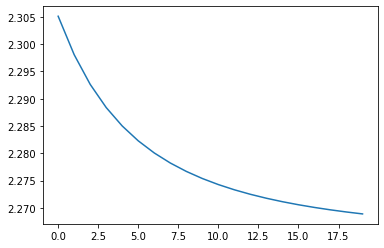

In [23]:
# Import packages needed to read and print our data
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

# Declare PATH_to_Dataset
ROOT_PATH = "C:/Users/USER/Desktop/Datasets/Kaggle_Digit_Recognizer/"

# List the files in the ROOT_PATH
print(f"In the Root Path, there are {os.listdir(ROOT_PATH)}")

# Store the file names in the ROOT_PATH
CSV_TEST = ROOT_PATH + "test.csv"
CSV_TRAIN= ROOT_PATH + "train.csv"

# Initialize Parameters
K_C1, b_C1, hparam_C1, hparam_S2, K_C3, b_C3, hparam_C3, hparam_S4, K_C5, b_C5, hparam_C5, W7, W8 = Initialize_Parameters(-0.01, 0.01)

# Read CSV File Through Pandas
DF_TRAIN = pd.read_csv(CSV_TRAIN)
DF_TRAIN_NO_LABLE = DF_TRAIN.drop(columns=["label"], axis=0)
Epoch = 20
loss_list = []

i = 1
lr = 0.01
for epoch in range(Epoch):
    tmp_list = []
    tic = time.time()
    for i in range(len(DF_TRAIN[:50])):
        
        # 1. Pick one example
        X, Y = pick_an_example(i, DF_TRAIN)
        X = X / 255.0
        Y_truth = np.zeros((1,10))
        Y_truth[0][Y] = 1
    
        # 2. Forward Pass
        cache_C1, X_A1, cache_S2, cache_C3, X_A3, cache_S4, cache_C5, X_A5, X_A6, X_A7, X_A8, Y_pred = LeNet5_forward(X, K_C1, b_C1, hparam_C1, hparam_S2, K_C3, b_C3, hparam_C3, hparam_S4, K_C5, b_C5, hparam_C5, W7, W8)
    
        # 3. Cross Entropy Loss
        tmp_list.append(cross_entropy(Y_pred, Y_truth))
        
        # 4. Backward Pass
        D_W8, D_W7, D_K_C5, D_b_C5, D_K_C3, D_b_C3, D_K_C1, D_b_C1 = LeNet5_backward(cache_C1, X_A1, cache_S2, cache_C3, X_A3, cache_S4, cache_C5, X_A5, X_A6, X_A7, X_A8, Y_pred, Y_truth)
    
        # 5. Update Weights
        W8, W7, K_C5, b_C5, K_C3, b_C3, K_C1, b_C1 = update_trainable_parameters(lr, D_W8, W8, D_W7, W7, D_K_C5, K_C5, D_b_C5, b_C5, D_K_C3, K_C3, D_b_C3, b_C3, D_K_C1, K_C1, D_b_C1, b_C1)
        #if epoch % 10 == 0: lr = lr * 0.3
        
        print(f"[{round(cross_entropy(Y_pred, Y_truth),4)}] The {i}-th example: \nY_pred: {Y_pred},\nY_truth: {Y_truth}\n")
    loss_list.append(np.mean(tmp_list))
    toc = time.time()
    #print(f"[{round(toc - tic, 2)} (s)] \nIn The {epoch}-th epoch: the avg. loss is {np.mean(tmp_list)}\nThe {i}-th example: \nY_pred: {Y_pred},\nY_truth: {Y_truth}\n")
    
    
plt.plot(loss_list)

In [21]:
import pandas as pd
import os
import collections

# Declare PATH_to_Dataset
ROOT_PATH = "C:/Users/USER/Desktop/Datasets/Kaggle_Digit_Recognizer/"

# List the files in the ROOT_PATH
print(f"In the Root Path, there are {os.listdir(ROOT_PATH)}")

# Store the file names in the ROOT_PATH
CSV_TEST = ROOT_PATH + "test.csv"
CSV_TRAIN= ROOT_PATH + "train.csv"

DF_TRAIN = pd.read_csv(CSV_TRAIN)

print(collections.Counter(DF_TRAIN["label"][:50]))

In the Root Path, there are ['sample_submission.csv', 'test.csv', 'train.csv']
Counter({1: 8, 3: 7, 4: 6, 9: 6, 0: 5, 7: 5, 2: 5, 8: 3, 6: 3, 5: 2})
